# Disease dagnosis with machine learning
## Diagnising common diseases among Nigeria student.

In [4]:
! pip install xgboost --quiet
! pip install catboost --quiet
! pip install shap --quiet
! pip install lightgbm --quiet
! pip install optuna --quiet

In [2]:
# importing the needed library
import shap
import math
import pandas as pd
import numpy as np
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt

from sklearn.preprocessing import OrdinalEncoder, LabelEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler, Normalizer
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

import optuna
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from joblib import dump
import warnings
warnings.filterwarnings('ignore')
plt.style.use('fivethirtyeight')
%matplotlib inline

In [3]:
train_data = pd.read_csv('/content/Training.csv')
test_data = pd.read_csv('/content/Testing.csv')

In [5]:
train_data.head()

,itching,skin_rash,nodal_skin_eruptions,continuous_sneezing,shivering,chills,joint_pain,stomach_pain,acidity,ulcers_on_tongue,...,scurring,skin_peeling,silver_like_dusting,small_dents_in_nails,inflammatory_nails,blister,red_sore_around_nose,yellow_crust_ooze,prognosis,Unnamed: 133
0,1,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,Fungal infection,NaN
1,0,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,Fungal infection,NaN
2,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,Fungal infection,NaN
3,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,Fungal infection,NaN
4,1,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,Fungal infection,NaN


In [ ]:
test_data.head()

,itching,skin_rash,nodal_skin_eruptions,continuous_sneezing,shivering,chills,joint_pain,stomach_pain,acidity,ulcers_on_tongue,muscle_wasting,vomiting,burning_micturition,spotting_ urination,fatigue,weight_gain,anxiety,cold_hands_and_feets,mood_swings,weight_loss,restlessness,lethargy,patches_in_throat,irregular_sugar_level,cough,high_fever,sunken_eyes,breathlessness,sweating,dehydration,indigestion,headache,yellowish_skin,dark_urine,nausea,loss_of_appetite,pain_behind_the_eyes,back_pain,constipation,abdominal_pain,diarrhoea,mild_fever,yellow_urine,yellowing_of_eyes,acute_liver_failure,fluid_overload,swelling_of_stomach,swelled_lymph_nodes,malaise,blurred_and_distorted_vision,...,movement_stiffness,spinning_movements,loss_of_balance,unsteadiness,weakness_of_one_body_side,loss_of_smell,bladder_discomfort,foul_smell_of urine,continuous_feel_of_urine,passage_of_gases,internal_itching,toxic_look_(typhos),depression,irritability,muscle_pain,altered_sensorium,red_spots_over_body,belly_pain,abnormal_menstruation,dischromic _patches,watering_from_eyes,increased_appetite,polyuria,family_history,mucoid_sputum,rusty_sputum,lack_of_concentration,visual_disturbances,receiving_blood_transfusion,receiving_unsterile_injections,coma,stomach_bleeding,distention_of_abdomen,history_of_alcohol_consumption,fluid_overload.1,blood_in_sputum,prominent_veins_on_calf,palpitations,painful_walking,pus_filled_pimples,blackheads,scurring,skin_peeling,silver_like_dusting,small_dents_in_nails,inflammatory_nails,blister,red_sore_around_nose,yellow_crust_ooze,prognosis
0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Fungal infection
1,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Allergy
2,0,0,0,0,0,0,0,1,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,GERD
3,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Chronic cholestasis
4,1,1,0,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Drug Reaction


In [6]:
train_data.columns

Index(['itching', 'skin_rash', 'nodal_skin_eruptions', 'continuous_sneezing',
       'shivering', 'chills', 'joint_pain', 'stomach_pain', 'acidity',
       'ulcers_on_tongue',
       ...
       'scurring', 'skin_peeling', 'silver_like_dusting',
       'small_dents_in_nails', 'inflammatory_nails', 'blister',
       'red_sore_around_nose', 'yellow_crust_ooze', 'prognosis',
       'Unnamed: 133'],
      dtype='object', length=134)

The top disease common among Nigeria students are: Common Cold, Urinary tract infection, Pneumonia, Bronchial Asthma, Acne, Migraine, Hypertension, Gastroenteritis, Allergy, Tuberculosis, Peptic ulcer diseae, Typhoid, Hepatitis B, Hepatitis C, Hepatitis A, Hepatitis E, Malaria, Chickenpox, Diabetes.

In [25]:
common_disease = ['Peptic ulcer diseae', 'Diabetes ', 'Gastroenteritis', 'Common Cold', 'Malaria', 'Chicken pox', 'hepatitis A', 'Migraine', 'Hypertension ',
       'Hepatitis B', 'Hepatitis C', 'Hepatitis D', 'Hepatitis E', 'Urinary tract infection', 'Bronchial Asthma', 'Pneumonia', 'Acne', 'Allergy', 'Typhoid',
                  'Tuberculosis',]

train_data = train_data[train_data['prognosis'].isin(common_disease)]

In [26]:
train_data.isnull().values.any()

True

In [27]:
train_data['prognosis'].value_counts()

Allergy                    120
Peptic ulcer diseae        120
Acne                       120
Pneumonia                  120
Common Cold                120
Tuberculosis               120
Hepatitis E                120
Hepatitis D                120
Hepatitis C                120
Hepatitis B                120
hepatitis A                120
Typhoid                    120
Chicken pox                120
Malaria                    120
Migraine                   120
Hypertension               120
Bronchial Asthma           120
Gastroenteritis            120
Diabetes                   120
Urinary tract infection    120
Name: prognosis, dtype: int64

In [28]:
len(train_data['prognosis'].value_counts())

20

In [29]:
train_data.describe()

,itching,skin_rash,nodal_skin_eruptions,continuous_sneezing,shivering,chills,joint_pain,stomach_pain,acidity,ulcers_on_tongue,...,blackheads,scurring,skin_peeling,silver_like_dusting,small_dents_in_nails,inflammatory_nails,blister,red_sore_around_nose,yellow_crust_ooze,Unnamed: 133
count,2400.000000,2400.000000,2400.0,2400.000000,2400.000000,2400.000000,2400.000000,2400.0,2400.00000,2400.0,...,2400.000000,2400.000000,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,0.0
mean,0.095000,0.095000,0.0,0.092500,0.045000,0.285000,0.142500,0.0,0.04750,0.0,...,0.045000,0.045000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
std,0.293276,0.293276,0.0,0.289791,0.207347,0.451509,0.349635,0.0,0.21275,0.0,...,0.207347,0.207347,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
min,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.00000,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
25%,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.00000,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
50%,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.00000,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
75%,0.000000,0.000000,0.0,0.000000,0.000000,1.000000,0.000000,0.0,0.00000,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
max,1.000000,1.000000,0.0,1.000000,1.000000,1.000000,1.000000,0.0,1.00000,0.0,...,1.000000,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN


In [30]:
train_data.shape

(2400, 134)

### Feature selection based on weight and correlation

<Axes: >

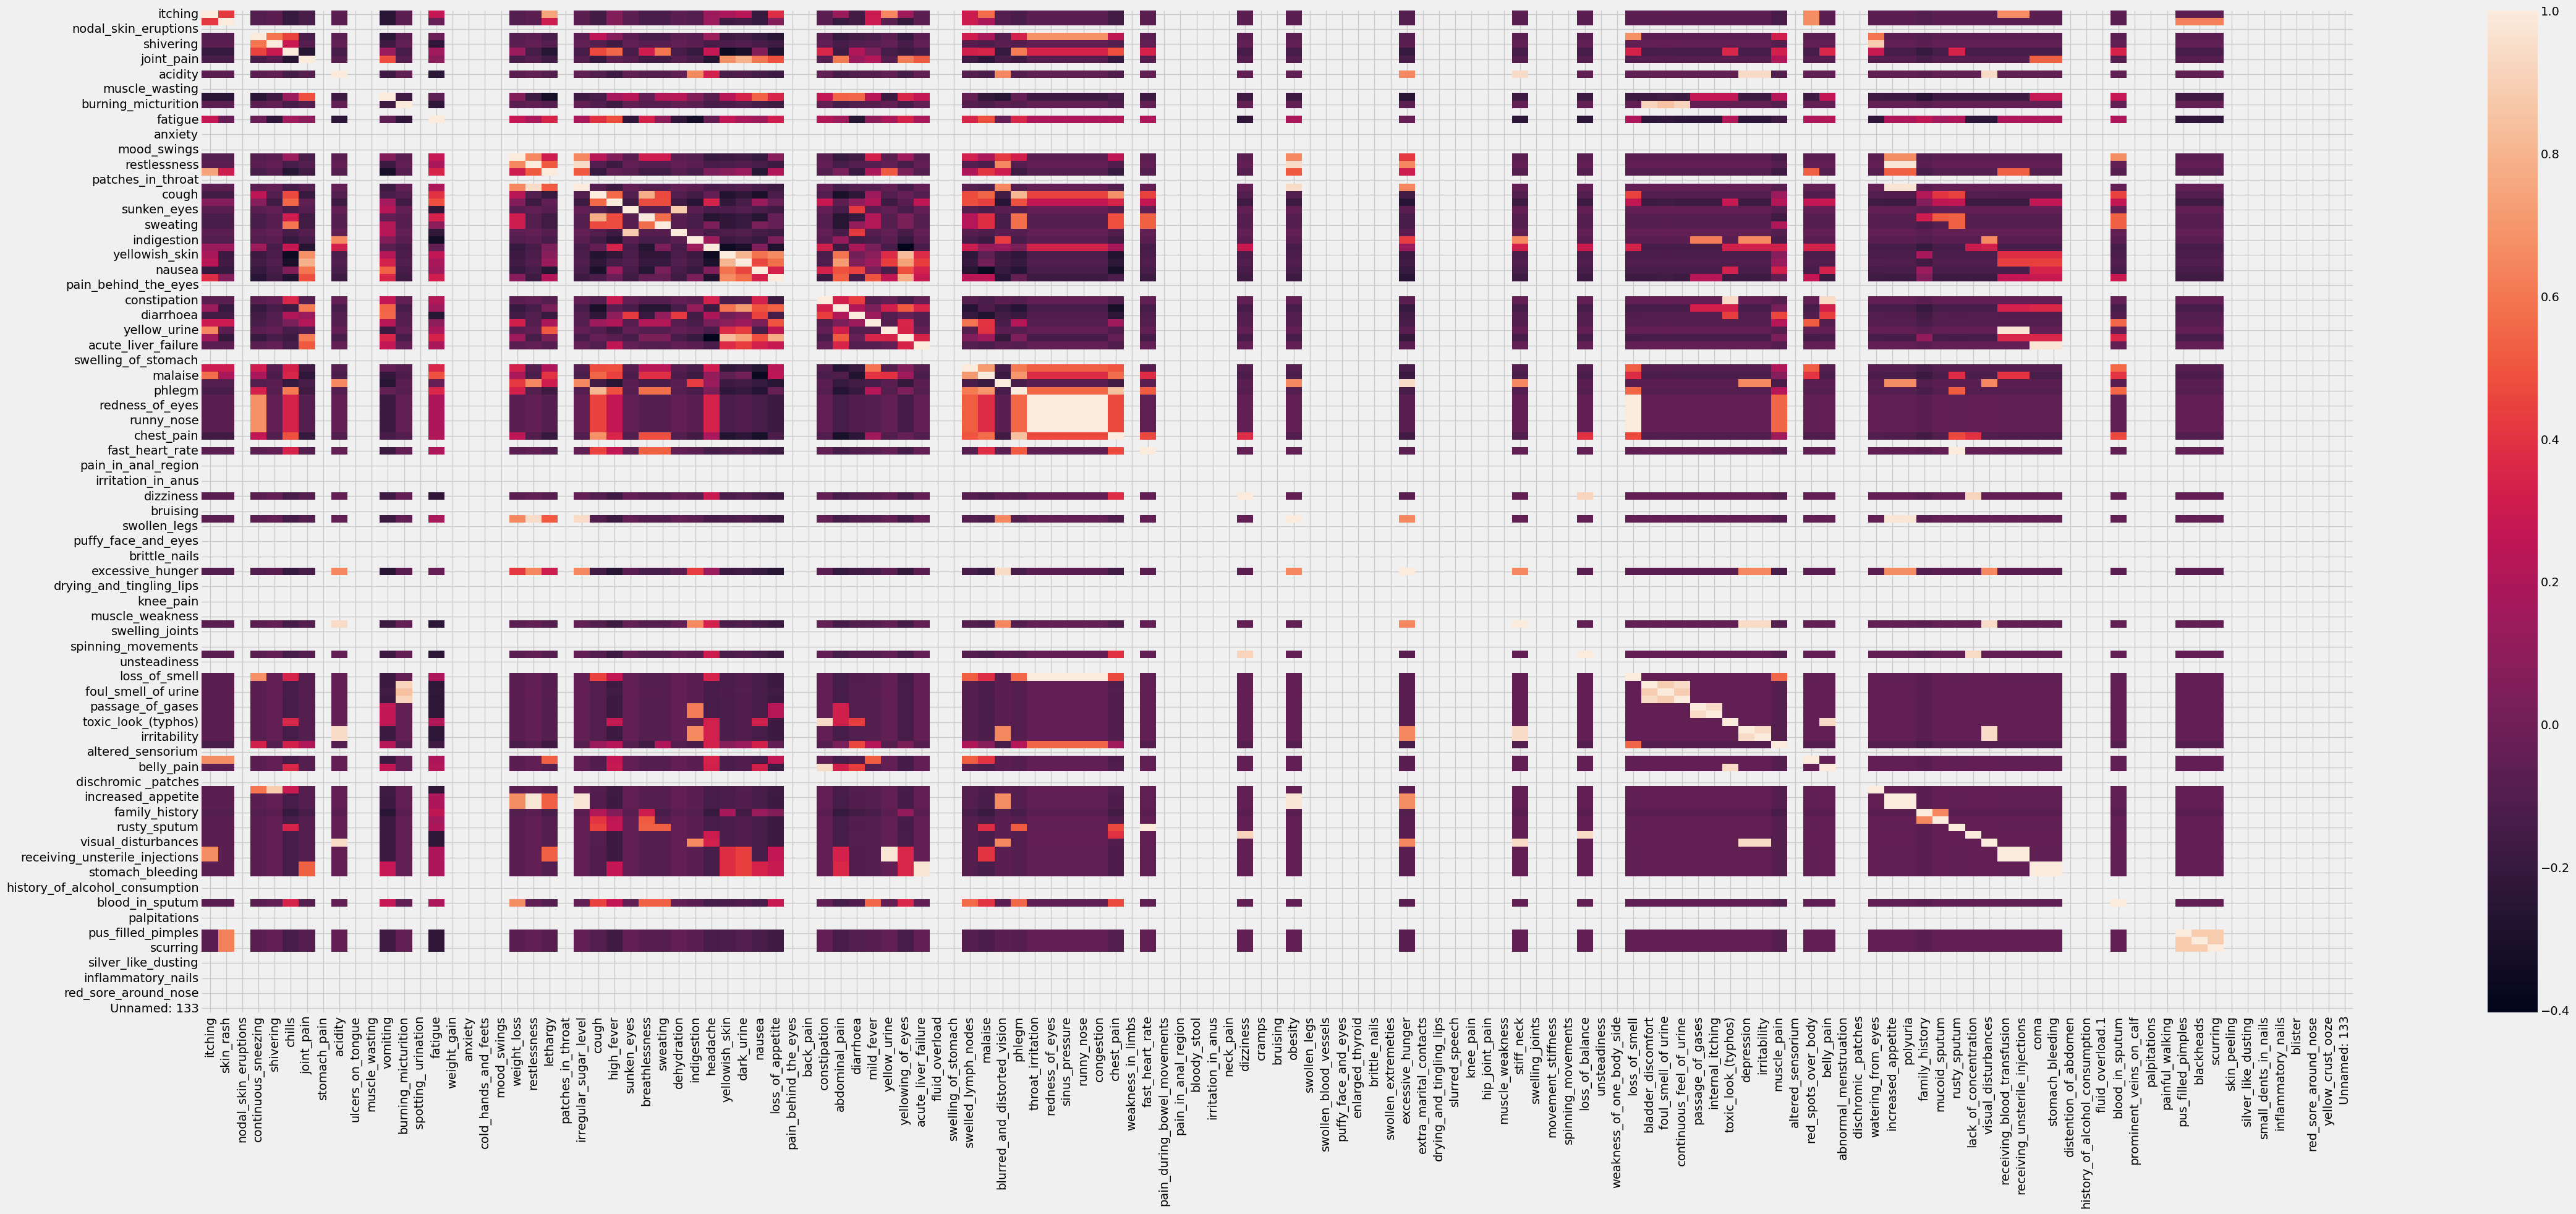

In [31]:
plt.figure(figsize = (50, 20))
sns.heatmap(train_data.corr())

In [32]:
# Dropping the correlated values with 80% and above correlation

corr_matrix = train_data.corr()

# Set the correlation threshold for removal
corr_threshold = 0.8

# Find and remove correlated features
col_to_remove = set()
for i in range(len(corr_matrix.columns)):
    for j in range(i):
        if abs(corr_matrix.iloc[i, j]) > corr_threshold:
            col_name = corr_matrix.columns[i]
            col_to_remove.add(col_name)

tdata = train_data.drop(columns=col_to_remove)

In [33]:
tdata.shape

(2400, 99)

In [34]:
le = LabelEncoder()
x = tdata.drop(['prognosis'], axis = 1)# independent features
y = le.fit_transform(tdata['prognosis'])# dependent features

In [35]:
# Splitting the dataset into train and test set
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 3)

In [36]:
xgb = XGBClassifier()
xgb.fit(x_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [37]:
#checking if xgboost is overfitted or underfitted with with cross validation
scores = cross_val_score(XGBClassifier(), x_train, y_train,
                              cv=7,
                              scoring="accuracy")

print("MAE score:\n", scores.mean())

MAE score:
 1.0


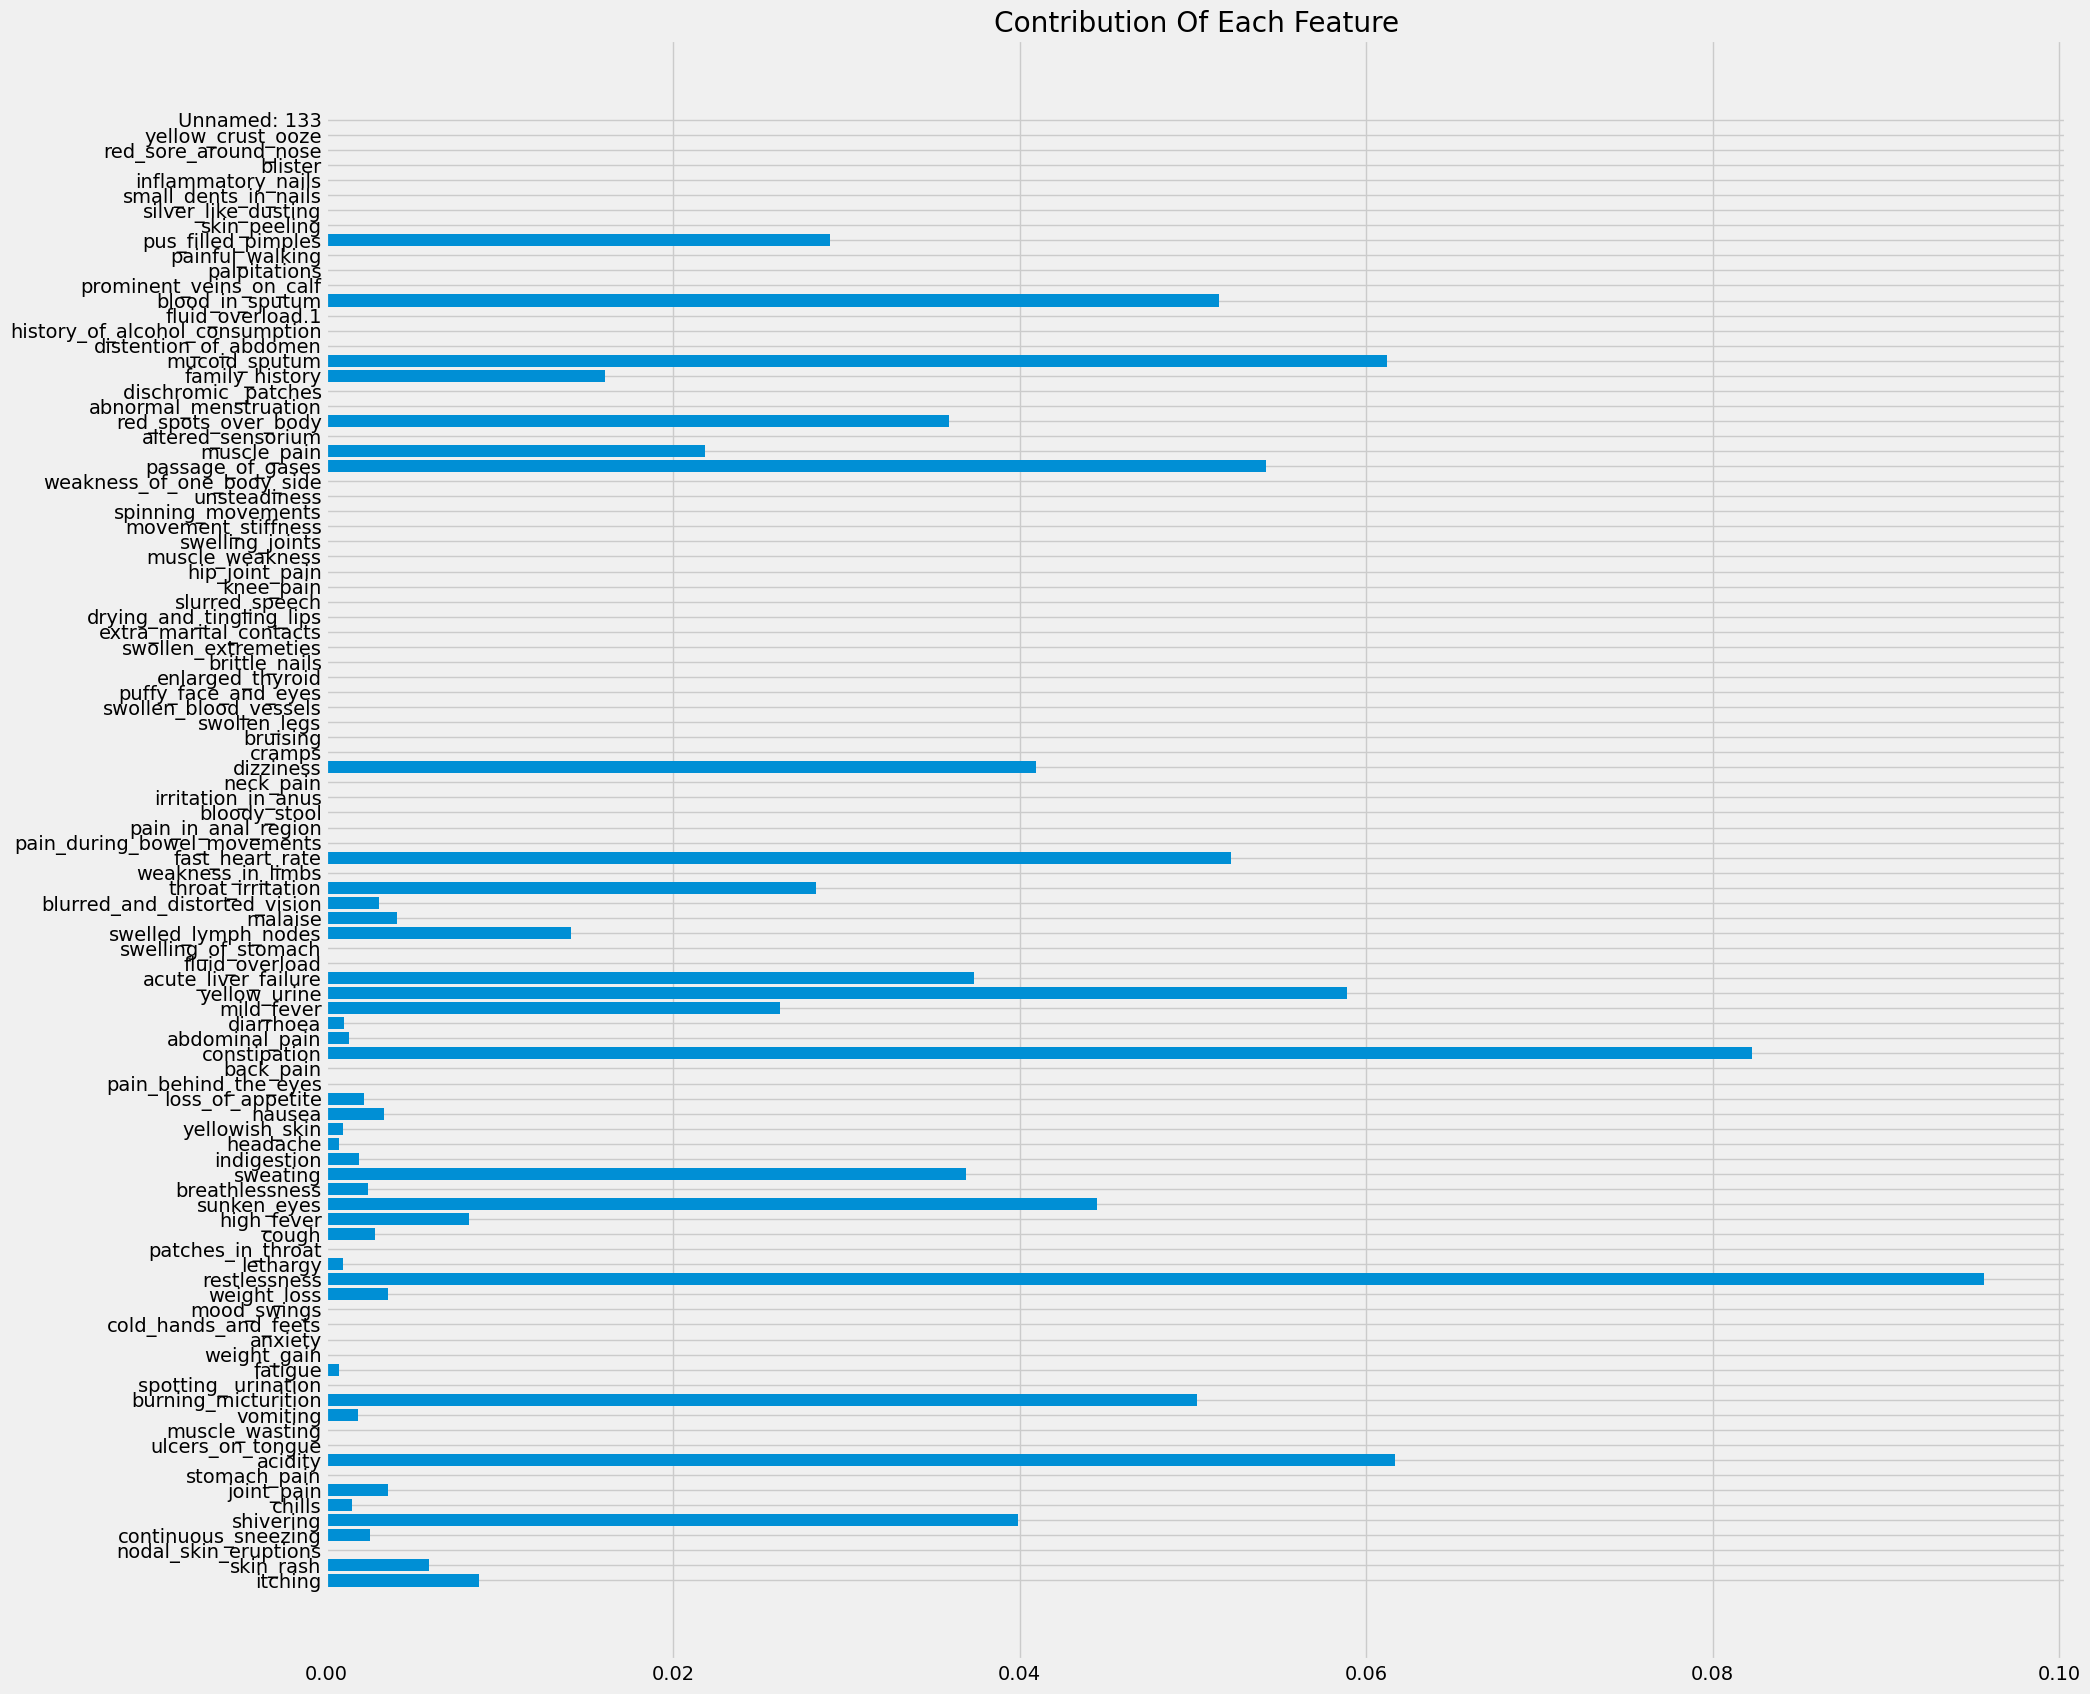

In [38]:
plt.figure(figsize=(20, 20))
plt.barh(x.columns, xgb.feature_importances_)
plt.title("Contribution Of Each Feature")
plt.show()

In [43]:
fi_df = pd.DataFrame({'Feature': x.columns, 'Importance': xgb.feature_importances_})

fi_df = fi_df.sort_values(by='Importance', ascending=False)

fi_df.head(42)

,Feature,Importance
20,restlessness,0.095631
35,constipation,0.082260
8,acidity,0.061642
81,mucoid_sputum,0.061190
39,yellow_urine,0.058879
74,passage_of_gases,0.054236
48,fast_heart_rate,0.052218
85,blood_in_sputum,0.051511
12,burning_micturition,0.050239
25,sunken_eyes,0.044460


In [44]:
# Selecting only the top 45 features
fi_df['Feature'][: 42].unique()

array(['restlessness', 'constipation', 'acidity', 'mucoid_sputum',
       'yellow_urine', 'passage_of_gases', 'fast_heart_rate',
       'blood_in_sputum', 'burning_micturition', 'sunken_eyes',
       'dizziness', 'shivering', 'acute_liver_failure', 'sweating',
       'red_spots_over_body', 'pus_filled_pimples', 'throat_irritation',
       'mild_fever', 'muscle_pain', 'family_history',
       'swelled_lymph_nodes', 'itching', 'high_fever', 'skin_rash',
       'malaise', 'joint_pain', 'weight_loss', 'nausea',
       'blurred_and_distorted_vision', 'cough', 'continuous_sneezing',
       'breathlessness', 'loss_of_appetite', 'indigestion', 'vomiting',
       'chills', 'abdominal_pain', 'diarrhoea', 'lethargy',
       'yellowish_skin', 'fatigue', 'headache'], dtype=object)

In [92]:
new_df = train_data[['restlessness', 'constipation', 'acidity', 'mucoid_sputum',
       'yellow_urine', 'passage_of_gases', 'fast_heart_rate',
       'blood_in_sputum', 'burning_micturition', 'sunken_eyes',
       'dizziness', 'shivering', 'acute_liver_failure', 'sweating',
       'red_spots_over_body', 'pus_filled_pimples', 'throat_irritation',
       'mild_fever', 'muscle_pain', 'family_history',
       'swelled_lymph_nodes', 'itching', 'high_fever', 'skin_rash',
       'malaise', 'joint_pain', 'weight_loss', 'nausea',
       'blurred_and_distorted_vision', 'cough', 'continuous_sneezing',
       'breathlessness', 'loss_of_appetite', 'indigestion', 'vomiting',
       'chills', 'abdominal_pain', 'diarrhoea', 'lethargy',
       'yellowish_skin', 'fatigue', 'headache', 'prognosis']]

In [46]:
new_df.head()

,restlessness,constipation,acidity,mucoid_sputum,yellow_urine,passage_of_gases,fast_heart_rate,blood_in_sputum,burning_micturition,sunken_eyes,...,loss_of_appetite,indigestion,vomiting,chills,abdominal_pain,diarrhoea,lethargy,yellowish_skin,fatigue,headache
10,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
11,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
12,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
13,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
14,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0


- After dropping correlated columns and dropping columns with less feature importance, the remaining 46 columns will be used for further analysis and modelling.

## Exploratory Data Analysis
### Univariate analysis

In [47]:
#writing a function to plot two features
def countplot(first, second):
  fig, ax = plt.subplots(1, 2, figsize = [13,5])

  sns.countplot(x = new_df[first], ax = ax[0]).set_title(f"{first} distribution")
  sns.countplot(x = new_df[second], ax = ax[1]).set_title(f"{second} distribution")

  fig.show()

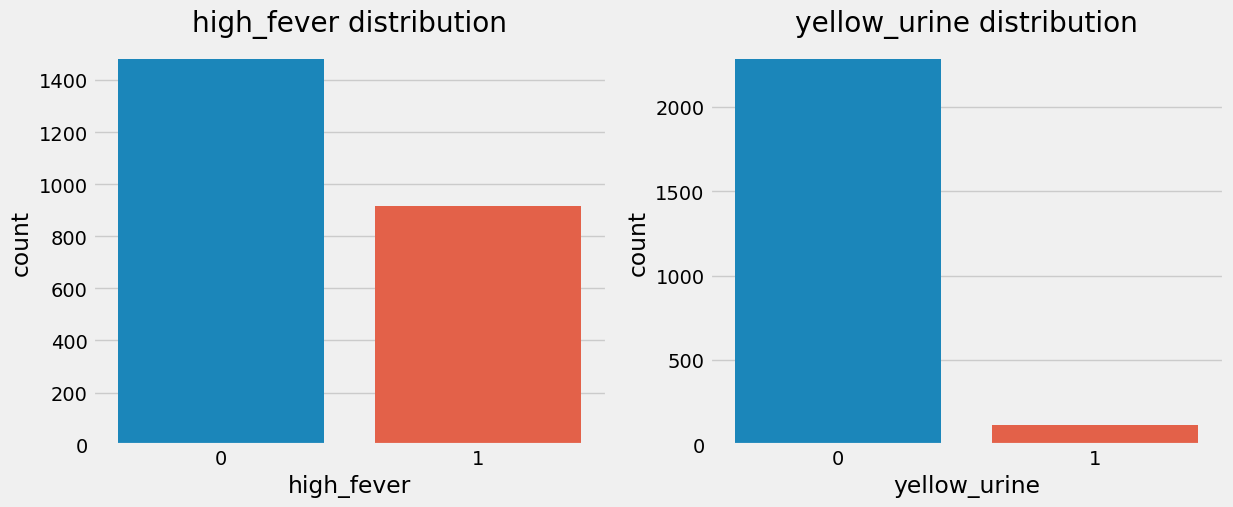

In [48]:
countplot('high_fever', 'yellow_urine')

- From the observation, most of the poeple do not have high fever and yellow urine.

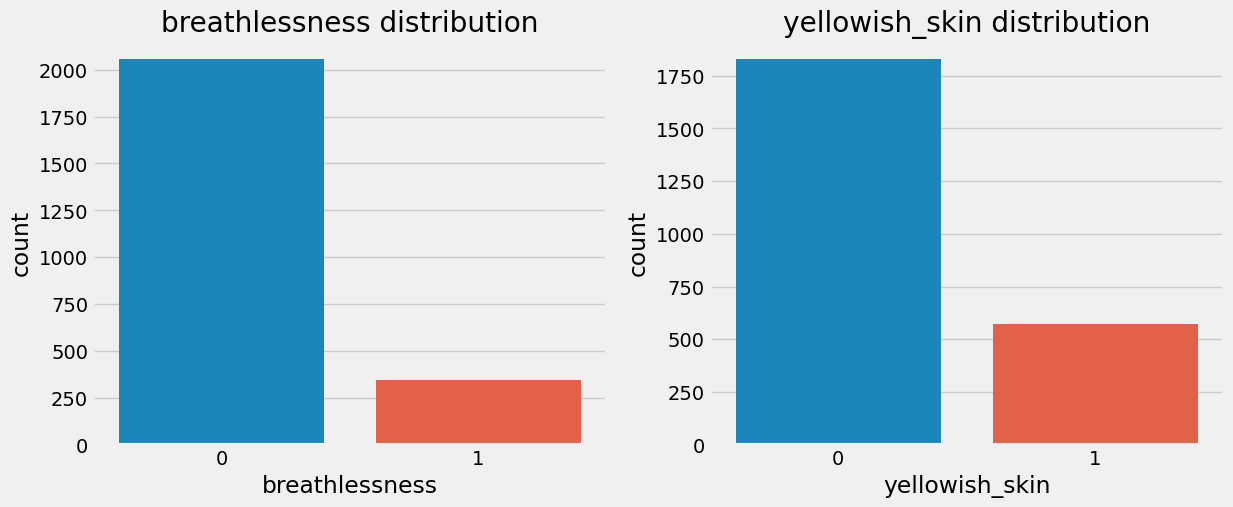

In [49]:
countplot('breathlessness', 'yellowish_skin')

- Most of the people do not have breathlessness as well as yellow skin

- Most of the people co not have muscle wasting and skin peeling and a correlation can be observed from the two features. One of the features will be dropped

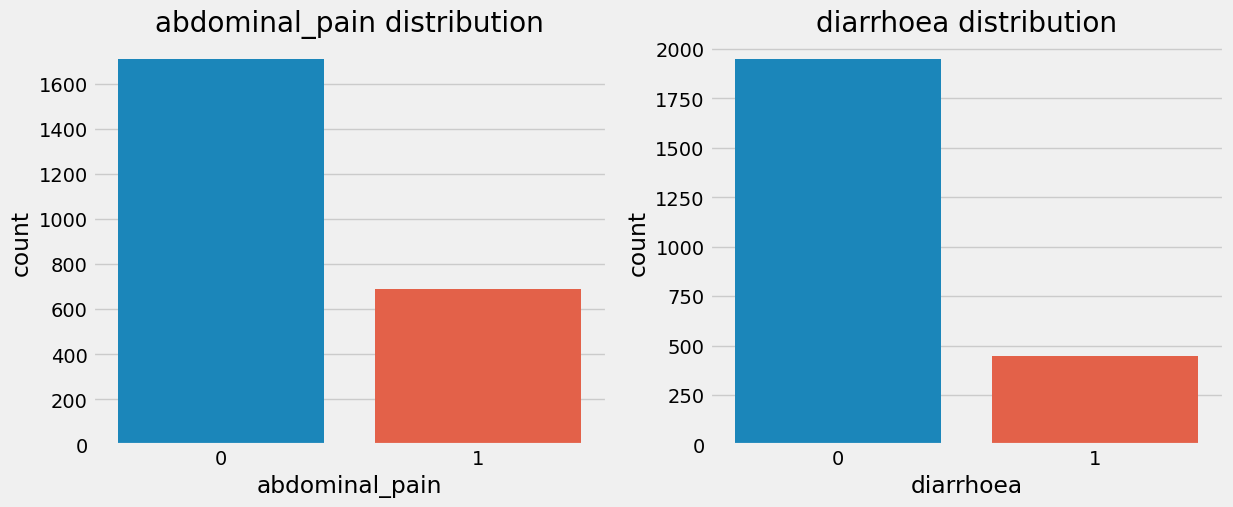

In [54]:
countplot('abdominal_pain', 'diarrhoea')

In [90]:
new_df.columns

Index(['fast_heart_rate', 'dizziness', 'acute_liver_failure', 'mild_fever',
       'muscle_pain', 'swelled_lymph_nodes', 'itching', 'high_fever',
       'malaise', 'cough', 'continuous_sneezing', 'breathlessness', 'vomiting',
       'chills', 'abdominal_pain', 'yellowish_skin', 'fatigue', 'headache'],
      dtype='object')

In [61]:
def mvc(first_column, second_columns, third_columns, fourth_columns, fifth_columns, sixth_columns, sevth_columns):
  columns = [first_column, second_columns, third_columns, fourth_columns, fifth_columns, sixth_columns, sevth_columns]

  for column in columns:
    value_counts = new_df[column].value_counts()
    print(f"Value Counts for {column}:\n{value_counts}")
    print("\n" + "-"*30 + "\n")

In [83]:
# mvc('fast_heart_rate', 'dizziness', 'acute_liver_failure', 'sweating',
#        'mild_fever', 'muscle_pain', 'swelled_lymph_nodes')

Value Counts for fast_heart_rate:
0    2280
1     120
Name: fast_heart_rate, dtype: int64

------------------------------

Value Counts for dizziness:
0    2292
1     108
Name: dizziness, dtype: int64

------------------------------

Value Counts for acute_liver_failure:
0    2286
1     114
Name: acute_liver_failure, dtype: int64

------------------------------

Value Counts for sweating:
0    2058
1     342
Name: sweating, dtype: int64

------------------------------

Value Counts for mild_fever:
0    2046
1     354
Name: mild_fever, dtype: int64

------------------------------

Value Counts for muscle_pain:
0    2040
1     360
Name: muscle_pain, dtype: int64

------------------------------

Value Counts for swelled_lymph_nodes:
0    2052
1     348
Name: swelled_lymph_nodes, dtype: int64

------------------------------



In [93]:
new_df = new_df.drop(['restlessness', 'constipation', 'acidity', 'mucoid_sputum', 'yellow_urine', 'passage_of_gases', 'blood_in_sputum',
                      'burning_micturition', 'sunken_eyes', 'shivering', 'red_spots_over_body', 'weight_loss', 'blurred_and_distorted_vision',
                      'throat_irritation', 'pus_filled_pimples', 'family_history', 'skin_rash', 'indigestion', 'lethargy', 'sweating',
                      'joint_pain', 'loss_of_appetite', 'nausea', 'diarrhoea'], axis = 1)

## Bi variate Analysis

In [94]:
def countplott(first, second, third):
  fig, ax = plt.subplots(1, 2, figsize = [13,5])

  sns.countplot(x = new_df[first], hue = new_df[second], ax = ax[0]).set_title(f"Relationship between {first} and {second}")
  sns.countplot(x = new_df[first], hue = new_df[third], ax = ax[1]).set_title(f"Relationship between {first} and {third}")

  fig.show()

KeyError: ignored

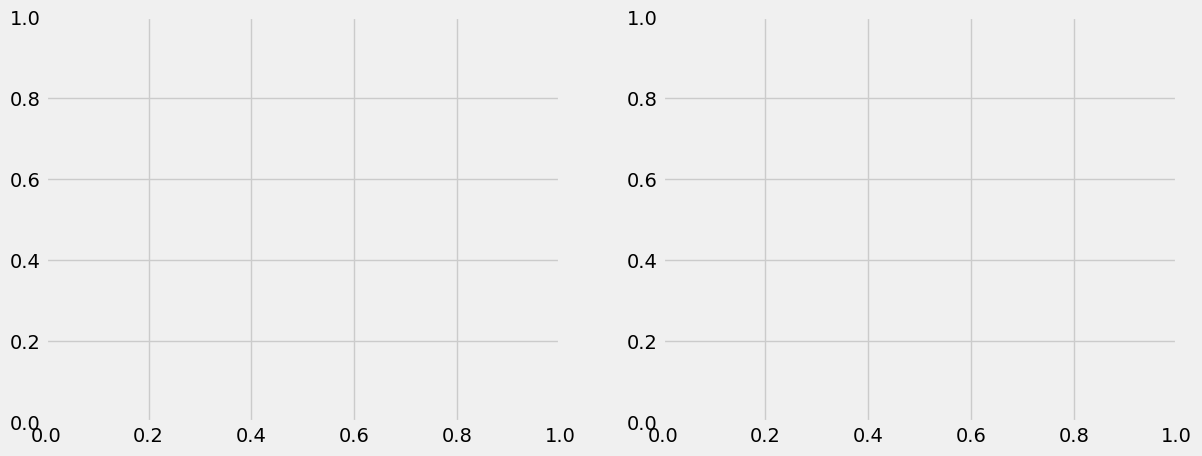

In [95]:
countplott('anxiety', 'high_fever', 'yellow_urine')

- Most of the peoplw that do not have anxiety do not have high fever as well
- Most of the peoplw that do not have anxiety do not have yellow urine as well and none of the peole that have anxiety have yeloo blood

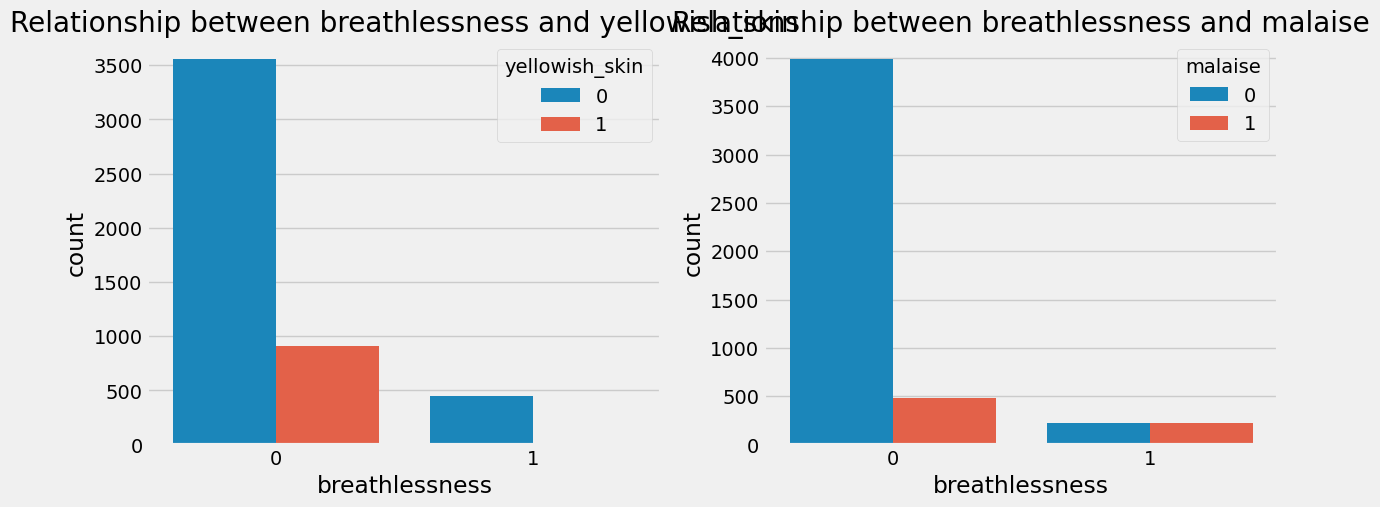

In [ ]:
countplott('breathlessness', 'yellowish_skin', 'malaise')

<Axes: >

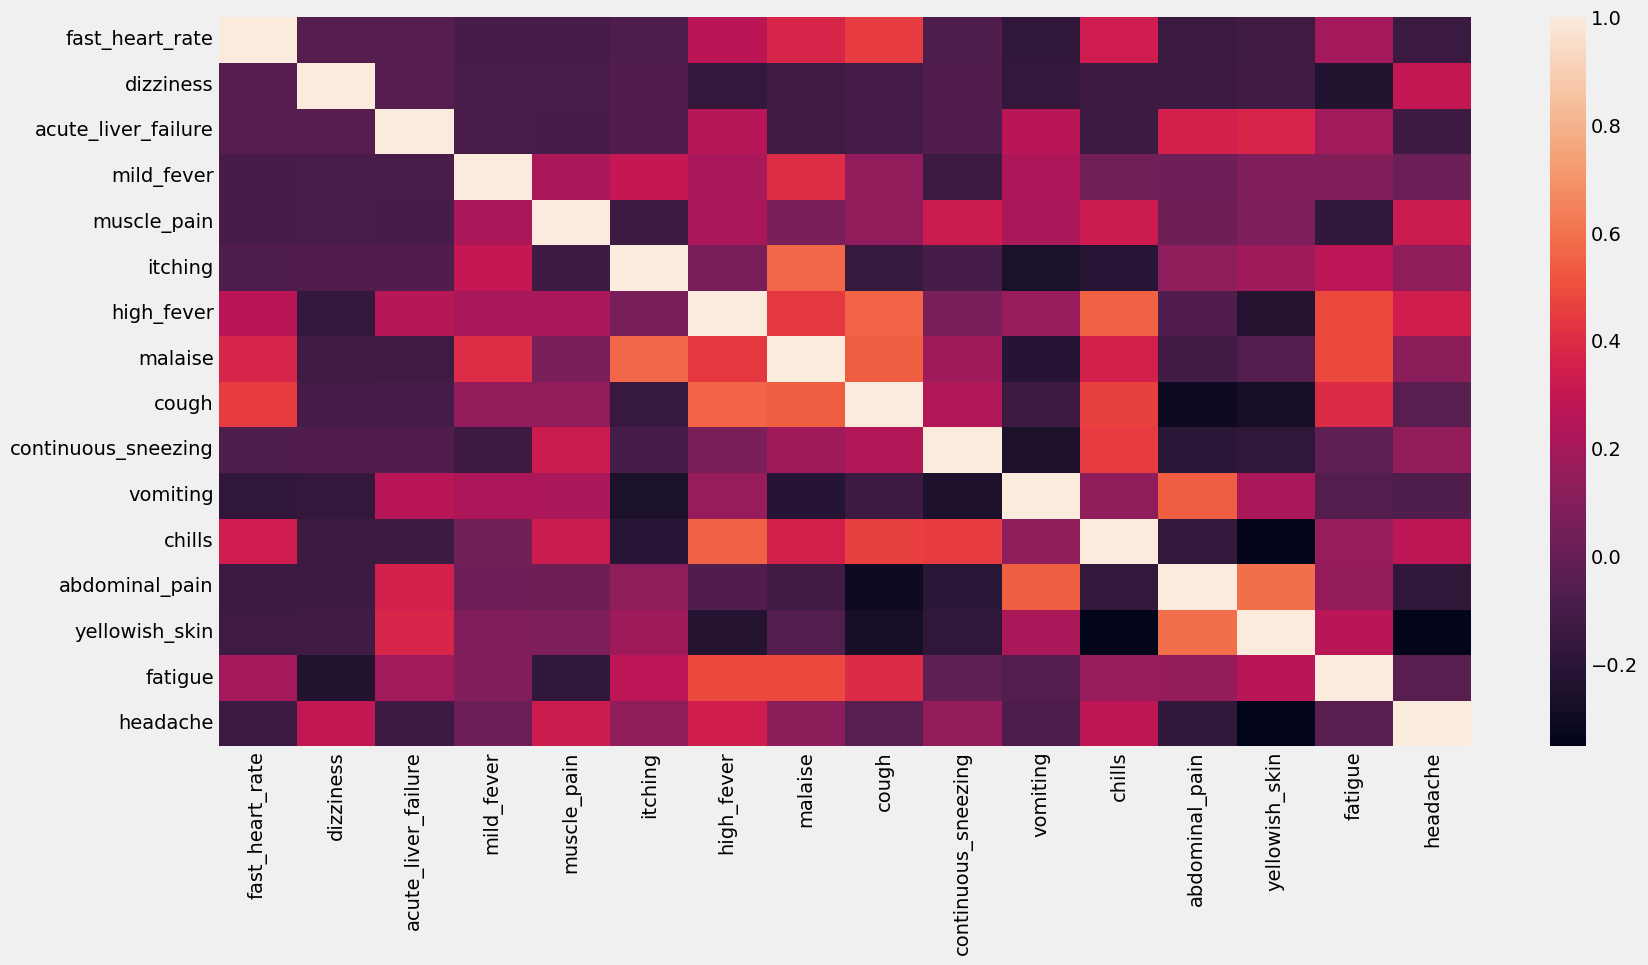

In [101]:
plt.figure(figsize = (18, 9))
sns.heatmap(new_df.corr())

In [100]:
new_df.columns

Index(['fast_heart_rate', 'dizziness', 'acute_liver_failure', 'mild_fever',
       'muscle_pain', 'itching', 'high_fever', 'malaise', 'cough',
       'continuous_sneezing', 'vomiting', 'chills', 'abdominal_pain',
       'yellowish_skin', 'fatigue', 'headache', 'prognosis'],
      dtype='object')

In [99]:
new_df = new_df.drop(['swelled_lymph_nodes', 'breathlessness'], axis = 1)

In [102]:
new_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2400 entries, 10 to 4917
Data columns (total 17 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   fast_heart_rate      2400 non-null   int64 
 1   dizziness            2400 non-null   int64 
 2   acute_liver_failure  2400 non-null   int64 
 3   mild_fever           2400 non-null   int64 
 4   muscle_pain          2400 non-null   int64 
 5   itching              2400 non-null   int64 
 6   high_fever           2400 non-null   int64 
 7   malaise              2400 non-null   int64 
 8   cough                2400 non-null   int64 
 9   continuous_sneezing  2400 non-null   int64 
 10  vomiting             2400 non-null   int64 
 11  chills               2400 non-null   int64 
 12  abdominal_pain       2400 non-null   int64 
 13  yellowish_skin       2400 non-null   int64 
 14  fatigue              2400 non-null   int64 
 15  headache             2400 non-null   int64 
 16  progn

In [103]:
le = LabelEncoder()
x = new_df.drop(['prognosis'], axis = 1)# independent features
y = le.fit_transform(new_df['prognosis'])# dependent features

In [105]:
# Splitting the dataset into train and test set
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 3)
xgb = XGBClassifier()
xgb.fit(x_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [106]:
#checking if xgboost is overfitted or underfitted with with cross validation
scores = cross_val_score(XGBClassifier(), x_train, y_train,
                              cv=7,
                              scoring="accuracy")

print("MAE score:\n", scores.mean())

MAE score:
 0.9281239927955255


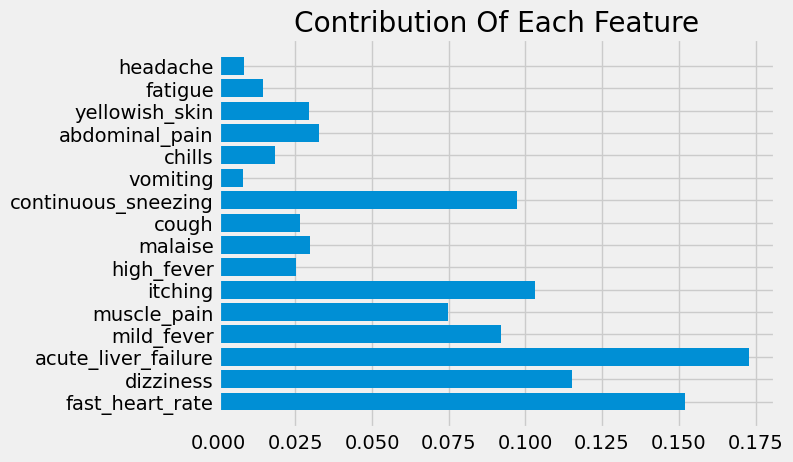

In [107]:
# plt.figure(figsize=(20, 20))
plt.barh(x.columns, xgb.feature_importances_)
plt.title("Contribution Of Each Feature")
plt.show()